In [516]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from collections import namedtuple, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from final_algo import attr_threshold
from paper_sims_util import confusion
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#ls ROC_N_25_p_50_*result* | wc -l
#scp uma@uhlergroup.mit.edu:~/MTP2-algorithm/ROC_N_25* .

In [688]:
N = 25
p = 50
d = None
if d is None:
    run_name = 'ROC_N_{}_p_{}'.format(N, p)
    d = 0.01
else:
    run_name = 'ROC_N_{}_p_{}_d_{}'.format(N, p, d)
NUM_GRAPHS = 20

In [731]:
if not os.path.isfile("{}_df.pkl".format(run_name)):
    all_results = []
    data = []
    for graph_num in range(NUM_GRAPHS):
        #print(graph_num)
        try:
            res = pickle.load(open('{}_{}_result.pkl'.format(run_name, graph_num), 'rb'))
        except:
            continue
        _, FPTP_dict, omega, _, recon_info = res
        all_results.append(FPTP_dict)
        for algo_name in FPTP_dict.keys():
            SH_special = False
            if algo_name == 'SH' and SH_special:
                start = time.time()
                SH_prec = recon_info['SH']
                for q in np.linspace(0.05, 1., num=40):
                    omega_hat = attr_threshold(SH_prec, q)
                    TP, TN, FP, FN = confusion(omega_hat, omega)
                    TPR = TP/(TP + FN)
                    FPR = FP/(FP + TN)
                    data.append((graph_num, algo_name, tuple((q,)), FPR, TPR))
                end = time.time()
                #print(end-start)
            else:
                for lamb, (FPR, TPR) in FPTP_dict[algo_name].items():
                    if type(lamb) != tuple:
                        lamb = tuple((lamb,))
                    data.append((graph_num, algo_name, lamb, FPR, TPR))
    df = pd.DataFrame(data, columns = ['RunID', 'AlgoName', 'lambda', 'FPR', 'TPR'])
    df.to_pickle('{}_df.pkl'.format(run_name))
    print(len(all_results), 'unique runs')
else:
    print("Loaded df {}".format(run_name))
    df = pd.read_pickle("{}_df.pkl".format(run_name))
    print(df.RunID.nunique(), 'unique runs')

Loaded df ROC_N_25_p_50
39 unique runs


In [740]:
agg_data = []
for key, item in df.groupby(['AlgoName', 'lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()
    FPR_std = item.FPR.std()
    TPR_std = item.TPR.std()
#     if key[0] == 'SH':
#         print(key[1])
#         print(item.FPR.values)
#         print(item.TPR.values)
#         print(item.TPR.mean())
#         print(item.TPR.std())
#         print()
    algo_name = key[0]
    run_id = item.RunID
    agg_data.append((run_id, algo_name, key[1], FPR_rate, TPR_rate, FPR_std, TPR_std))

In [729]:
no_agg_data = []
for key, item in df.groupby(['AlgoName', 'lambda']):
    FPR_rate = item.FPR.mean()
    TPR_rate = item.TPR.mean()

    algo_name = key[0]
    run_id = item.RunID
    for fpr, tpr in zip(item.FPR, item.TPR):
        no_agg_data.append((run_id, algo_name, key[1], fpr, tpr, None, None))

In [741]:
agg_df = pd.DataFrame(agg_data, columns=['RunID','Algorithm', 'Lambda', 'False Positive Rate', 'True Positive Rate', 'FPR_std', 'TPR_std'])




In [746]:
agg_df

,RunID,Algorithm,Lambda,False Positive Rate,True Positive Rate,FPR_std,TPR_std
0,20 0 106 1 191 2 277 3 36...,SH,"(0.5,)",0.076773,0.460160,0.005220,0.339744
1,21 0 107 1 192 2 278 3 36...,SH,"(0.5263157894736842,)",0.081213,0.462132,0.005363,0.340433
2,22 0 108 1 193 2 279 3 36...,SH,"(0.5526315789473684,)",0.085526,0.466991,0.005617,0.340810
3,23 0 109 1 194 2 280 3 36...,SH,"(0.5789473684210527,)",0.089755,0.470959,0.005734,0.344558
4,24 0 110 1 195 2 281 3 36...,SH,"(0.6052631578947368,)",0.094196,0.472791,0.005944,0.346072
5,25 0 111 1 196 2 282 3 36...,SH,"(0.631578947368421,)",0.098319,0.483047,0.005971,0.352597
6,26 0 112 1 197 2 283 3 36...,SH,"(0.6578947368421053,)",0.102633,0.486405,0.006242,0.355395
7,27 0 113 1 198 2 284 3 37...,SH,"(0.6842105263157895,)",0.106861,0.493199,0.006402,0.358685
8,28 0 114 1 199 2 285 3 37...,SH,"(0.7105263157894737,)",0.111069,0.502025,0.006494,0.357089
9,29 0 115 1 200 2 286 3 37...,SH,"(0.7368421052631579,)",0.115446,0.504874,0.006661,0.358876


In [719]:
agg_df[(agg_df.Algorithm == 'SH')].sort_values('True Positive Rate')

,RunID,Algorithm,Lambda,False Positive Rate,True Positive Rate
63,21 0 107 1 192 2 278 3 36...,SH,"(0.5263157894736842,)",0.084367,0.0
689,37 0 123 1 208 2 294 3 38...,SH,"(0.9473684210526315,)",0.146623,0.0
727,38 0 124 1 209 2 295 3 38...,SH,"(0.9736842105263157,)",0.151191,0.0
556,34 0 120 1 205 2 291 3 37...,SH,"(0.868421052631579,)",0.138728,0.0
88,22 0 108 1 193 2 279 3 36...,SH,"(0.5526315789473684,)",0.088357,0.0
439,31 0 117 1 202 2 288 3 37...,SH,"(0.7894736842105263,)",0.126342,0.0
726,38 0 124 1 209 2 295 3 38...,SH,"(0.9736842105263157,)",0.156328,0.0
445,31 0 117 1 202 2 288 3 37...,SH,"(0.7894736842105263,)",0.137336,0.0
688,37 0 123 1 208 2 294 3 38...,SH,"(0.9473684210526315,)",0.147083,0.0
610,35 0 121 1 206 2 292 3 37...,SH,"(0.8947368421052632,)",0.138866,0.0


In [710]:
small_df = agg_df[agg_df['Algorithm'].isin(['our', 'SH'])]

In [711]:
nice_names = {
    'our': "Our Algorithm",
    'SH': 'Slawski-Hein',
    'glasso': 'Graphical Lasso',
    'nbsel': 'Neighborhood Selection',
    'anand': 'CCT'
}

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


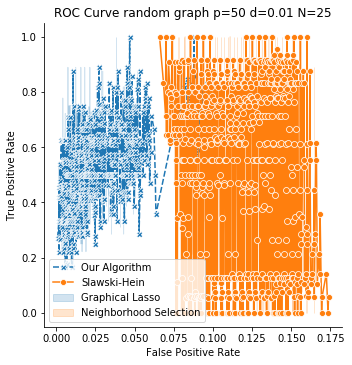

In [712]:
g = sns.relplot(x='False Positive Rate', y='True Positive Rate', data = small_df, kind='line', 
            hue='Algorithm',
            hue_order=nice_names.keys(),
            style='Algorithm',
            markers = True,
            legend=False)
g.fig.get_axes()[0].legend(nice_names.values())
g.fig.get_axes()[0].set_title("ROC Curve random graph p={} d={} N={}".format(p,d,N))
g.fig.savefig("{}_noisy.png".format(run_name))